<a href="https://colab.research.google.com/github/xjxgyc/NLP_study/blob/task-20190809/BERT%E5%BE%AE%E8%B0%83%E5%8F%A5%E5%AD%90%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 引言

2018年一篇论文”[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)”腾空出世，刷新了11项NLP任务的最优性能记录。这有点像前几年CNN参加Image Net比赛，刷新了图像识别领域记录，从而让全球掀起了一场人工智能风暴时的场景。基本上也宣告了NLP进入一个新纪元。

BERT出现并非偶然，其中提出的技术，实际上也并非之前都没有出现过，我更愿将其看成是NLP最新技术的一个集大成者，它综合了Attention，Transformer，ELMO, GPT等的优点，从而达到现今的成果。

### 历史

2018年是NLP的突破性一年。迁移学习，特别是像Allen AI的ELMO，OpenAI的Open-GPT和Google的BERT这样的模型，研究人员可以通过最少的特定任务微调，突破多个基准测试，并为NLP社区的其余部分提供可轻松实现的预训练模型（数据更少），该模型可以减少计算时间并进行微调达到最先进的结果。不幸的是，对于许多NLP新手，甚至对于一些经验丰富的实践者来说，这些强大模型的理论和实际应用仍然不是很好。


### BERT是什么?

BERT（Bidirectional Encoder Representations from Transformers）于2018年末发布，是我们将在本教程中使用的模型，为读者提供在NLP中使用迁移学习模型的更好理解和实用指导。 BERT是一种预训练语言表示的方法，对于NLP实践者随后可以免费下载和使用的模型。你可以使用这些模型从文本数据中提取高质量的语言功能，也可以使用你自己的数据在特定任务（分类，实体识别，问答等）上微调这些模型，以达到最先进的预测结果。









## 安装和导入包

Google Colab提供免费的GPU和TPU！由于我们将训练一个大型神经网络，最好使用这个（在这种情况下我们将使用一个GPU），否则训练将需要很长时间。

通过转到菜单并选择以下内容来添加GPU：


修改 -> 笔记本设置 -> 硬件加速器 (GPU)

然后运行以下单元格以确认已检测到GPU。



In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


接下来，让我们通过Hugging Face为BERT安装pytorch接口。 （该库包含其他预训练语言模型的接口，如OpenAI的GPT和GPT-2。）我们选择pytorch接口，因为它在高级API（易于使用但不需要关注事物是如何工作的）和tensorflow代码（其中包含许多细节，但经常会让我们陷入关于tensorflow的细节中，当这里的目的是BERT时！）之间取得了很好的平衡。

目前，Hugging Face库似乎是用于处理BERT的最广泛和强大的pytorch接口。除了支持各种不同的预训练语言模型（以及未来出现的模型 - BERT将不是最先进的模型），该库还包括适合在特定任务下BERT的预构建修改。例如，在本教程中，我们将使用`BertForSequenceClassification`，但该库还包括BERT设计的修改，适用于标记分类，问题回答，下一个句子的预测等。使用这些预构建的类简化了修改BERT的过程。

**注意**：截至2019年7月，名为“pytorch-pretrained-bert pytorch-nlp”的pytorch库已更新并重命名为“pytorch-transformers”。虽然旧名称仍然有效，但[这里](https://github.com/huggingface/pytorch-transformers#Migrating-from-pytorch-pretrained-bert-to-pytorch-transformers)有一个关于迁移到新库的简短介绍。 （这主要涉及一些名称更改。）



In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


为了让torch使用GPU，我们需要识别并指定GPU作为运行设备。稍后，在我们的训练循环中，我们将数据加载到设备上。

 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## 导入数据


我们将使用语言可接受语料库（CoLA）数据集对单句进行分类。这是一组标记为语法正确或不正确的句子。数据格式如下：


**列1**:	表示句子来源的代码.

**列2**:	可接受性判断标签 (0=不接受, 1=接受).

**列3**:	最初由作者注明的可接受性判断.

**列4**:	句子.

从此链接下载数据集，提取并将其移动到本地驱动器。

https://nyu-mll.github.io/CoLA/

数据的标记化和原始版本都可用。我们将使用**raw**版本，因为我们需要使用BERT tokenizer将文本分解为模型能够识别的标记和块。



In [6]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving in_domain_train.tsv to in_domain_train.tsv


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [8]:
df.shape

(8551, 4)

In [9]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7152,sks13,1,NaN,They would have been walking for hours.
5480,b_73,1,NaN,He's such the tall man.
5571,c_13,0,*,Bill kissed herself.
1313,r-67,1,NaN,When did you get back and what did you bring me?
2803,l-93,0,*,The fence hit.
6420,d_98,1,NaN,John bought any picture of Queen Elizabeth tha...
2696,l-93,1,NaN,Amanda carried packages to New York.
5914,c_13,1,NaN,The stodgy professor left with his teaching as...
5856,c_13,1,NaN,That Harry loves dancing is evidenced by his s...
2629,l-93,1,NaN,Doug cleared the dishes from under the rack.


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

## 输入

*接下来*，导入BERT tokenizer，用于将文本转换为与BERT词汇表对应的标记。


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 423513.00B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


**BERT**需要特殊格式的输入。对于每个标记化的输入句子，我们需要创建：

- **input ids**：在BERT tokenizer词汇表中将每个输入标记标识映射到整数序列的索引

- **segment mask**:（可选）对于一个输入是1和0的序列的，识别输入是一个句子还是两个句子。对于一个输入句子，这只是一个0的序列。对于两个输入句子，第一个句子的每个标记为0，第二个句子的每个标记为1

- **attention mask**: （可选）1和0的序列，所有输入标记都是1，所有填充标记都是0（我们将在下一段中详细说明）
- **labels**: 单个值为1或0.在我们的任务1中表示“合语法”，0表示“不合语法”

虽然我们可以使用可变长度的输入句子，但BERT要求我们的输入数组大小相同。我们首先选择最长句子长度，然后填充和截断我们的输入直到每个输入序列具有相同的长度来解决这个问题。

在这种情况下“填充”我们的输入意味着如果一个句子比最大句子长度短，我们只需将0添加到序列的末尾，直到它是最大句子长度。

如果一个句子长于最大句子长度，那么我们只需截断序列的结尾将其丢弃。

我们填充并截断我们的序列，使它们都变为长度`MAX_LEN`（“post”表示我们想要在序列的末尾填充和截断，而不是从开头开始）`pad_sequences`是一个实用函数，我们借用Keras。它只是处理Python列表的截断和填充。



In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

*创建* attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## 训练model

现在我们的输入数据格式正确，是时候微调BERT模型了。

对于此任务，我们首先要修改预先训练的BERT模型以提供分类输出，然后我们希望继续在我们的数据集上训练模型，直到整个模型端到端，非常适合于我们的任务。值得庆幸的是，huggingface pytorch实现了一组为各种NLP任务设计的接口。虽然这些接口都是建立在已经训练的BERT模型之上，但每个接口都有不同的顶层和输出类型，以适应其特定的NLP任务。



我们将下载[BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129).这是正常的BERT模型，在顶部添加了单个线性层，用于分类，我们将其作为句子分类器。当我们提供输入数据时，整个预先训练的BERT模型和额外未训练的分类层将根据我们的特定任务进行训练。



### 微调模型的结构

正如我们事先说明的那样，每个序列的第一个标记是特殊的分类标记(`[CLS]`)。与对应于正常单词标记的隐藏状态向量不同，对应于该特殊标记的隐藏状态由BERT的作者指定, 使用分类任务的整个句子的聚合表示来指定。因此，当我们在训练期间向我们的模型提供输入句子时，输出是对应于该标记的长度为768隐藏状态向量。我们在顶部添加的附加层由大小为`[hidden_state，number_of_labels]`的未经训练的线性神经元组成，大小即为`[768,2]`，意味着BERT的输出加上我们的分类层是两个数字的向量，代表为”语法/非语法“的得分，然后进入交叉熵损失。



### 微调的过程

因为预先训练的BERT层已经编码了许多关于语言的信息，所以训练分类器相对便宜。它不是从头开始训练大型模型中的每一层，底层95％已经被训练，相对比较固定，只需要训练顶层，并且进行一些调整。以较低的水平，来适应我们的任务。

有时，实践者会选择在微调时“冻结”某些层，或者应用不同的学习率，应用递减的学习率等等，所有这些都是为了保证网络中的高质量权重并加快训练。实际上，最近对BERT的研究已经证明，冻结大部分权重只会导致精度下降最小，但也有一些例外和更广泛的迁移学习规则需要认真考虑。例如，如果你的任务和微调数据集与用于训练迁移学习模型的数据集非常不同，那么冻结权重可能不是一个好主意。我们将在以后的文章中介绍NLP中更广泛的迁移学习。

 



好吧，让我们加载BERT！有许多不同的预训练BERT模型可供选择。 “bert-base-uncased”表示只有小写字母（“unased”）的版本，并且是两者中较小的版本（“base”与“large”）。



In [20]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:33<00:00, 12288039.35B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

现在我们已经加载了模型，我们需要从存储的模型中获取训练超参数。  



为了进行微调，作者建议使用以下超参数范围： 
- batch大小：16, 32
- 学习率（Adam）：5e-5, 3e-5, 2e-5 
- 迭代数：2, 3, 4



In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [22]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

W0822 10:44:18.465147 139858193721216 optimization.py:46] t_total value of -1 results in schedule not being applied


以下是我们的训练循环。有很多事情会发生，但从根本上说，我们循环中的每一次传递都有一个训练阶段和一个验证阶段。每次传递我们需要：

训练循环：

- 在训练模式下设置模型，告诉模型进行梯度计算 
- 解压我们的输入和标签数据 
- 将数据加载到GPU上进行加速
- 清除前一次传递中计算的梯度。在pytorch中，梯度会默认累积（对于像RNN这样的model很有用），除非你明确地清除它们
- 前向传播（给网络提供输入数据） 
- 向后传播（反向传播） 
- 告诉网络使用optimizer.step()来更新参数 
- 跟踪变量以监控进度

评估循环： 
- 在评估模式下设置模型，告诉模型不要计算梯度 
- 解压我们的输入和标签数据 
- 将数据加载到GPU上进行加速
- 前向传播（给网络提供输入数据）） 
- 计算我们在验证数据集上的损失并跟踪变量以监控进度


因此，请仔细阅读注释，以了解正在发生的事情。如果您对pytorch不熟悉，可以快速查看一些[新手教程](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)，将有助于向你展示训练循环涉及的几个简单的步骤;其余的通常只是一些装饰。

 

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4971236114803686


Epoch:  25%|██▌       | 1/4 [06:11<18:33, 371.02s/it]

Validation Accuracy: 0.8082561728395062
Train loss: 0.2620028560803392


Epoch:  50%|█████     | 2/4 [12:21<12:21, 370.95s/it]

Validation Accuracy: 0.8333333333333334
Train loss: 0.12713431587821467


Epoch:  75%|███████▌  | 3/4 [18:32<06:10, 370.84s/it]

Validation Accuracy: 0.8252314814814815
Train loss: 0.07300604058282752


Epoch: 100%|██████████| 4/4 [24:43<00:00, 370.81s/it]

Validation Accuracy: 0.8036265432098766


## 训练评估

让我们来看看在所有batch上的训练损失：


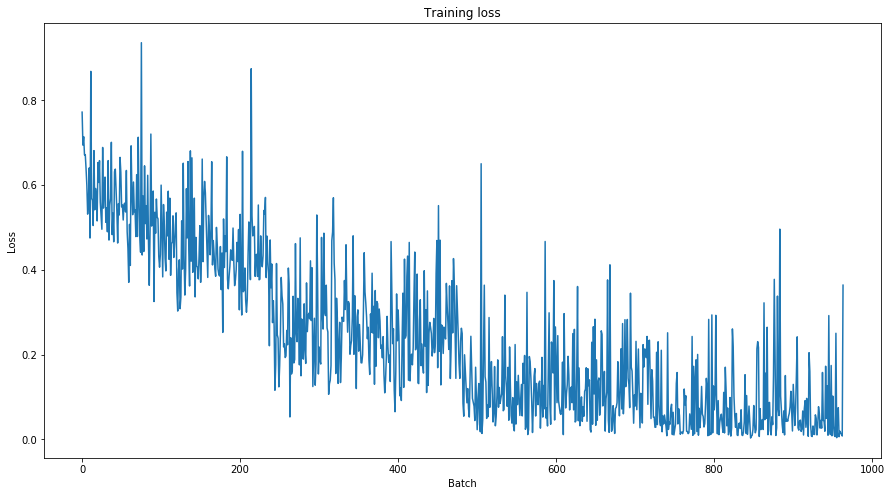

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## 对Holdout数据集的预测和评估


现在加载holdout数据集并准备输入数据，与训练集的操作一样。然后我们使用[马修斯相关系数](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)来评估预测，因为NLP社区经常使用马修斯相关系数作为评估CoLA性能的指标。使用此指标，+1是最佳分数，-1是最差分数。通过这种方式，我们可以知道在这些特定任务上最先进模型的表现如何。




In [34]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()


Saving out_of_domain_dev.tsv to out_of_domain_dev (1).tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [37]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


最终得分将基于整个测试集，让我们看一下各批次的得分，以了解批次之间度量的可变性。



In [38]:
matthews_set

[0.049286405809014416,
 -0.21684543705982773,
 0.6147253896340708,
 0.2757127976394358,
 0.21867346044008387,
 0.7562449037944323,
 0.4152273992686999,
 0.0,
 0.9229582069908973,
 0.41184152944810126,
 0.687932430407656,
 0.5465943944999485,
 0.6397114734243627,
 0.7141684885491869,
 0.5447047794019222,
 0.4133804997216296,
 0.0]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [40]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.47717866775231005

在半小时内没有进行任何超参数调整（调整学习速度，迭代数，批量大小，ADAM属性等），我们仍然能够获得良好的分数。同时我们还没有在整个训练数据集上进行训练，而因为代码的合法性将其中的一部分留作验证集。

如果你看一下[这里](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy)的排行榜，对于同一模型，你会发现我们使用小版BERT的得分（54，自己train的模型的得分比较低，没有达到54）实际上略微优于BERT作者的CoLA得分（52）。如果你想调整超参数，使用整个训练集，或者使用更大的BERT模型，你可能会把这个分数推高到60年代中期，这看起来像2019年7月的最新技术水平！




## 结论

这篇文章证明，使用预先训练的BERT模型，无论你感兴趣的NLP任务是什么，你都可以使用pytorch接口以最少的工作量和训练时间快速有效地创建高质量的模型。
